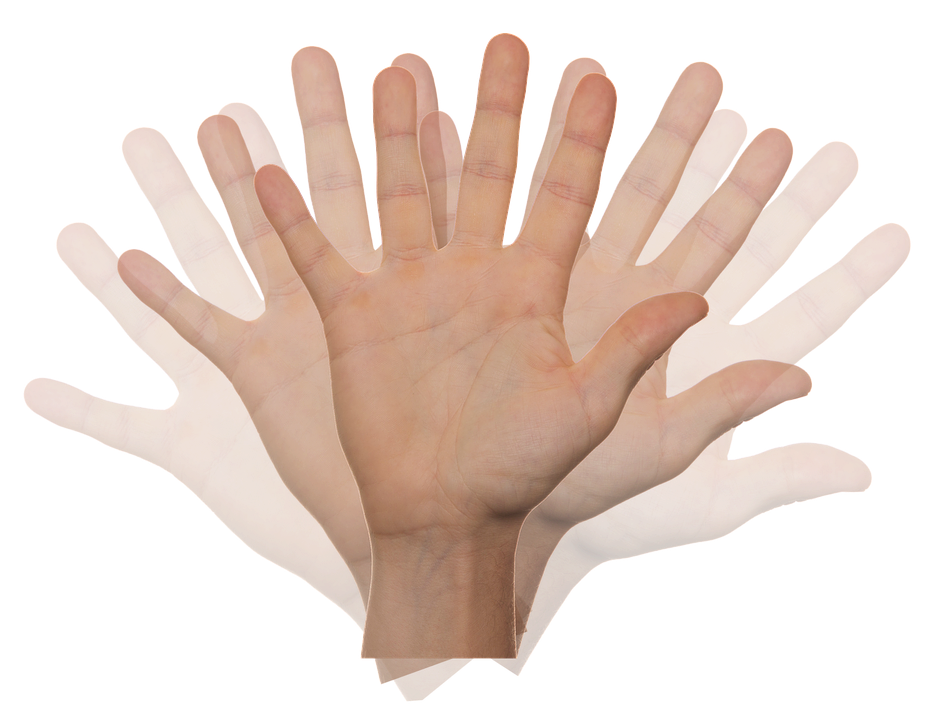

In [2]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import cv2

# Models
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Data Splitting
from sklearn.model_selection import train_test_split

# Scailing
from sklearn.preprocessing import StandardScaler

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
def rename(df, char):
    for col in df.columns:
        col1 = char+col
        df = df.rename({col: col1}, axis=1)
    return df

In [4]:
def split(df) :
    half = int(len(df)/2)
    hd = df.head(half)
    tl = df.tail(len(df)-half)
    hd = hd.reset_index(drop=True)
    tl = tl.reset_index(drop=True)
    return hd, tl

In [5]:
def combine(df,numOfRows):
    
    for i in range(1, numOfRows+1):
        line = ["{}{}".format(ind,'_'+str(i)) for ind in df.columns]
        if i==1:
            lineTotal = line
            lineArr = [line]
        else:
            lineTotal = lineTotal + line
            lineArr.append(line)

    headlines = pd.DataFrame(columns = lineTotal)

    
    for i in range(0, len(df)-len(df)%numOfRows, numOfRows):
    
        for j in range(0, numOfRows):
            listj = df.loc[i+j]
            listj.index = lineArr[j]
            if j==0:
                arr = [listj]
            else:
                arr.append(listj)
    
        jumpRows = pd.concat(arr)
        headlines = headlines.append(jumpRows, ignore_index = True)
        
    return headlines

In [6]:
HandRight = pd.read_csv(r'\Users\97254\Desktop\Hand Positions\extraFiles\HandRight.csv')
for col in HandRight.columns:
    col1 = col.replace(" ", "_")
    HandRight = HandRight.rename({col: col1}, axis=1)
HandRight = HandRight.rename({'_#_hands': 'hands_num'}, axis=1) 
HandRight = HandRight[HandRight._Hand_Type == 'right']
HandRight = HandRight.dropna().reset_index(drop=True)

In [7]:
def encode(path, num):
    df = pd.read_csv(path).iloc[8:,:]
      
    for col in df.columns:
        col1 = col.replace(" ", "_")
        df = df.rename({col: col1}, axis=1)
        
    df = df.rename({'_#_hands': 'hands_num'}, axis=1)  
     
    if num != 2:
        df = df[df.hands_num == 2]
        df = df.sort_values(by=['_Hand_Type'])
        left, right =split(df)
    else:
        left = df[df.hands_num == 1].reset_index(drop=True)
        right = HandRight.iloc[8:,:]
        if len(left)>len(right):
            right = right.append(right.iloc[8:(len(left)-len(right)+8),:]).reset_index(drop=True)
        else:
            right = right.iloc[:len(left),:]
        
    left = rename(left, 'L')
    right = rename(right, 'R')
    df = pd.concat([left, right], axis=1)
    df = df.drop(['LTime', 'RTime', 'L_Frame_ID', 'R_Frame_ID', 'Lhands_num', 'Rhands_num'], axis=1)
    
    df = df[df.index % 5 == 0].reset_index(drop=True)
    df = combine(df,3)
    
    df['label']=num
    
    return df

In [8]:
def var_name(variable):
    fullName=''
    for name in globals():
        if eval(name) is variable:
            fullName += name
    return fullName

In [9]:
def organize(df):
    df = df.drop(columns=df.columns[(df == 'left').any()])
    df = df.drop(columns=df.columns[(df == 'right').any()])
    df = df.sample(frac=1).dropna().reset_index(drop=True)
    return df

In [10]:
def loadData(files):
    if "train" in var_name(files):
        path = r'\Users\97254\Desktop\Hand Positions\extraFiles\Training\\'
    elif "test" in var_name(files):
        path = r'\Users\97254\Desktop\Hand Positions\extraFiles\Validation\\'
    arr=[]
    for file in files:
        type = None
        if "Spontan" in file:
            type = 0
        elif "Sync" in file:
            type = 1
        elif "Alone" in file:
            type = 2
                    
        df = encode(path+file,type)
        arr.append(df)
        print('loaded - File: ', file, ' Type: ', type)
    df = pd.concat(arr).reset_index(drop=True)
    df = organize(df)
    return df